In [152]:
import sys
import time
from os import listdir
import gzip

from collections import Counter
from itertools import chain, product

import numpy as np
from scipy import sparse
import random

In [153]:
chrom = '22'
fkey = ('AU1274', 'AU1274202', 'AU1274201')
ped_file = '../data/160826.ped'
data_dir = '../split_gen'
phase_dir = '../sherlock_phased'

sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, 'X' if chrom.startswith('PAR') else chrom)
variant_file = '%s/chr.%s.gen.variants.txt.gz' % (data_dir, 'X' if chrom.startswith('PAR') else chrom)
clean_file = '%s/clean_indices_%s.txt' % (data_dir, 'X' if chrom.startswith('PAR') else chrom) 
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % ('X' if chrom.startswith('PAR') else chrom)) in f and 'gen.npz' in f])


In [154]:
# genotype (pred, obs): cost
g_cost = {
	(-1, -1): 0,
	(-1, 0): 1,
	(-1, 1): 1,
	(-1, 2): 1,
	(0, -1): 1,
	(0, 0): 0,
	(0, 1): 1,
	(0, 2): 2,
	(1, -1): 1,
	(1, 0): 1,
	(1, 1): 0,
	(1, 2): 1,
	(2, -1): 1,
	(2, 0): 2,
	(2, 1): 1,
	(2, 2): 0
}

PAR1X = (60001, 2699520)
PAR2X = (154931044, 155260560)

# pull families with sequence data
with open(sample_file, 'r') as f:
	sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# pull families from ped file
families = dict()
with open(ped_file, 'r') as f:	
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        if child_id in sample_ids and f_id in sample_ids and m_id in sample_ids:
        	if (fam_id, m_id, f_id) not in families:
        		families[(fam_id, m_id, f_id)] = [m_id, f_id]
        	families[(fam_id, m_id, f_id)].append(child_id)

# randomly permute parents and children (separately)
family_to_mom_dad = dict([(k, tuple(x[:2])) for k, x in families.items()])
families = dict([(k, random.sample(x[:2], 2)+random.sample(x[2:], len(x)-2)) for k, x in families.items()])
family_to_indices = dict([(fid, [sample_id_to_index[x] for x in vs]) for fid, vs in families.items()])
family_to_index = dict([(fid, i) for i, fid in enumerate(families.keys())])

print('families with sequence data', len(families))

families with sequence data 886


In [155]:
family_indices = family_to_indices[fkey]
family_size = len(family_indices)
print('family size %d' % family_size)

family size 7


In [156]:
# ancestral_variants (m1, m2, p1, p2)
anc_variants = np.array(list(product(*[[0, 1]]*4)), dtype=np.int8)
anc_variant_to_index = dict([(tuple(x), i) for i, x in enumerate(anc_variants)])
print('ancestral variants', anc_variants.shape)

# pull genotype data from .npz
indices_of_interest = list(family_indices)
old_index_to_new_index = dict([(ind, i) for (i, ind) in enumerate(indices_of_interest)])
family_indices = [old_index_to_new_index[x] for x in family_indices]
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices_of_interest,:] for gen_file in gen_files])
m, n = whole_chrom.shape
print('chrom shape', m, n)

ancestral variants (16, 4)
chrom shape 7 1096535


In [157]:
# use only "cleaned" variants - must be SNPs and missingness in parents can't be sex-biased
snp_indices = []
snp_positions = []
with open(clean_file, 'r') as f:
    for i, line in enumerate(f):
        index, position = line.strip().split('\t')
        snp_indices.append(int(index))
        snp_positions.append(int(position))
snp_positions = np.array(snp_positions)

whole_chrom = whole_chrom[:, snp_indices].A
m, n = whole_chrom.shape
print('chrom shape only SNPs', m, n)

# filter out all_hom_ref
family_indices = np.where(np.sum(whole_chrom!=0, axis=0) != 0)[0]
whole_chrom = whole_chrom[:, family_indices]
snp_positions = snp_positions[family_indices]
n = snp_positions.shape[0]
print('chrom shape no hom ref', m, n)

# If we're looking at one of the PAR, restrict X to appropriate region
if chrom == 'PAR1':
	PAR1X_indices = np.where(np.logical_and(snp_positions >= PAR1X[0], snp_positions <= PAR1X[1]))[0]
	whole_chrom = whole_chrom[:, PAR1X_indices]
	snp_positions = snp_positions[PAR1X_indices]
elif chrom == 'PAR2':
	PAR2X_indices = np.where(np.logical_and(snp_positions >= PAR2X[0], snp_positions <= PAR2X[1]))[0]
	whole_chrom = whole_chrom[:, PAR2X_indices]
	snp_positions = snp_positions[PAR2X_indices]

chrom shape only SNPs 7 1003938
chrom shape no hom ref 7 88982


In [232]:
deletions = -np.ones((8, 7, n))
anc_dels = -np.ones((8, 4, n))
inh_state = -np.ones((8, 5, 2, n))
for family_size in range(3, 7):
    m = family_size
    print('Family size', m)
    # inheritance states
    #
    # for parents:
    # (0, 0) -> normal
    # (0, 1) -> deletion on parental2
    # (1, 0) -> deletion on parental1
    # (1, 1) -> deletion on parental1 and parental2
    # 
    # for children:
    # (0, 0) -> m1p1
    # (0, 1) -> m1p2
    # (1, 0) -> m2p1
    # (1, 1) -> m2p2

    if family_size >= 5:
        inheritance_states = list(product(*[[0, 1]]*(2*m)))
    else:
        inheritance_states = [x for x in product(*[[0, 1]]*(2*m)) if x[4] == 0 and x[5] == 0]
    inheritance_states = np.asarray(inheritance_states, dtype=np.int8)
    
    state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
    p = inheritance_states.shape[0]
    print('inheritance states', inheritance_states.shape)

    # genotypes
    genotypes = np.array(list(product(*[[-1, 0, 1, 2]]*m)), dtype=np.int8)
    genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(genotypes)])
    q = genotypes.shape[0]
    print('genotypes', genotypes.shape)

    # transition matrix
    # only allow one shift at a time
    shift_costs = [10]*4 + [500]*(2*(m-2))

    transitions = [[] for i in range(p)]
    transition_costs = [[] for i in range(p)]
    for i, state in enumerate(inheritance_states):
        # allow multiple deletion transitions
        for delstate in list(product(*[[0, 1]]*4)):
            new_state = tuple(delstate[:4]) + tuple(state[4:(2*m)])
            if new_state in state_to_index:
                new_index = state_to_index[new_state]
                transitions[i].append(new_index)
                transition_costs[i].append(sum([shift_costs[j] for j, (old_s, new_s) in enumerate(zip(state[:4], delstate)) if old_s != new_s]))

        # allow a single recombination event
        for j in range(4, 2*m):
            new_state = tuple(1-x if k == j else x for k, x in enumerate(state))
            if new_state in state_to_index:
                new_index = state_to_index[new_state]
                transitions[i].append(new_index)
                transition_costs[i].append(shift_costs[j])

    transitions = np.array(transitions)
    transition_costs = np.array(transition_costs)
    print('transitions', transitions.shape)

    # loss matrix
    losses = np.zeros((p, q), dtype=np.int16)
    for i, s in enumerate(inheritance_states):
        state_losses = np.zeros((q, anc_variants.shape[0]), dtype=np.int16)

        # mom
        if s[0] == 0 and s[1] == 0:
            pred_gens = anc_variants[:, 0] + anc_variants[:, 1]
        elif s[0] == 0:
            pred_gens = 2*anc_variants[:, 0]
        elif s[1] == 0:
            pred_gens = 2*anc_variants[:, 1]
        else:
            pred_gens = -1*np.ones((anc_variants.shape[0],))
        for obs_gen in [-1, 0, 1, 2]:
            state_losses[genotypes[:, 0]==obs_gen, :] += [g_cost[(pred_gen, obs_gen)] for pred_gen in pred_gens]

        # dad
        if s[2] == 0 and s[3] == 0:
            pred_gens = anc_variants[:, 2] + anc_variants[:, 3]
        elif s[2] == 0:
            pred_gens = 2*anc_variants[:, 2]
        elif s[3] == 0:
            pred_gens = 2*anc_variants[:, 3]
        else:
            pred_gens = -1*np.ones((anc_variants.shape[0],))
        for obs_gen in [-1, 0, 1, 2]:
            state_losses[genotypes[:, 1]==obs_gen, :] += [g_cost[(pred_gen, obs_gen)] for pred_gen in pred_gens]

        # children
        for index in range(m-2):
            mat, pat = s[(4+(2*index)):(6+(2*index))]
            
            mat_del = s[mat]
            pat_del = s[2+pat]

            if mat_del == 0 and pat_del == 0:
                pred_gens = anc_variants[:, mat] + anc_variants[:, 2+pat]
            elif mat_del == 0:
                pred_gens = 2*anc_variants[:, mat]
            elif pat_del == 0:
                pred_gens = 2*anc_variants[:, 2+pat]
            else:
                pred_gens = -1*np.ones((anc_variants.shape[0],))
                
            for obs_gen in [-1, 0, 1, 2]:
                state_losses[genotypes[:, 2+index]==obs_gen, :] += [g_cost[(pred_gen, obs_gen)] for pred_gen in pred_gens]

        losses[i, :] = np.min(state_losses, axis=1)

    print('losses', losses.shape, losses)

    # pull genotype data for this family
    family_genotypes = whole_chrom[:m, :]
    pos_to_genindex = np.asarray([genotype_to_index[tuple(x)] for x in family_genotypes.T])

    # viterbi
    v_cost = np.zeros((p, n+1), dtype=int)

    # forward sweep
    prev_time = time.time()
    v_cost[:, 0] = [2*s[4]+s[5] for s in inheritance_states]
    for j in range(n): 
        v_cost[:, j+1] = np.min(v_cost[transitions, j] + transition_costs, axis=1) + losses[:, pos_to_genindex[j]]
    print('Forward sweep complete', time.time()-prev_time, 'sec') 

    # backward sweep
    prev_time = time.time()

    # choose best path
    k = np.argmin(v_cost[:, n])
    print('Num solutions', np.sum(v_cost[:, n]==v_cost[k, n]))
    paths = [k]
    prev_state = tuple(inheritance_states[k, :])
    prev_state_end = n-1

    num_forks = 0
    index = n
    while index > 0:
        # traceback
        total_cost = v_cost[transitions[paths, :], index-1] + transition_costs[paths, :]
        min_value = np.min(total_cost, axis=1)
        new_states = set()
        for i, k in enumerate(paths):
            # get best tracebacks
            min_indices = transitions[k, np.where(total_cost[i, :] <= min_value[i])[0]]	
            new_states.update(min_indices.tolist())
        new_states = list(new_states)

        # combine into a single state (with missing values)
        new_state = tuple(inheritance_states[new_states[0], :])
        if len(new_states) > 1:
            num_forks += 1
            for k in new_states[1:]:
                new_state = tuple(['*' if x != y else x for x, y in zip(new_state, tuple(inheritance_states[k, :]))])

        # write to file
        if prev_state != new_state:
            start_index, end_index = index, prev_state_end
            del_state = [0 if s == '*' else s for s in prev_state[:4]]
                
            deletions[m, 0, start_index:(end_index+1)] = sum(del_state[:2])
            deletions[m, 1, start_index:(end_index+1)] = sum(del_state[2:4])
            
            anc_dels[m, :, start_index:(end_index+1)] = np.outer(del_state, np.ones((end_index-start_index+1,)))
            
            for k in range(m-2):
                mat, pat = prev_state[(4+(2*k)):(6+(2*k))]
            
                if mat != '*' and pat != '*':
                    deletions[m, k+2, start_index:(end_index+1)] = (del_state[mat]+del_state[2+pat])
                    anc_inh[m, mat, start_index:(end_index+1)] += 1
                    inh_state[m, k, 0, start_index:(end_index+1)] = mat
                    inh_state[m, k, 1, start_index:(end_index+1)] = pat
                    anc_inh[m, 2+pat, start_index:(end_index+1)] += 1
                elif (mat == '*') and (pat != '*') and (del_state[0] == del_state[1]):
                    deletions[m, k+2, start_index:(end_index+1)] = (del_state[0]+del_state[2+pat])
                    inh_state[m, k, 1, start_index:(end_index+1)] = pat
                elif (pat == '*') and (mat != '*') and (del_state[2] == del_state[3]):
                    deletions[m, k+2, start_index:(end_index+1)] = (del_state[mat]+del_state[2])
                    inh_state[m, k, 0, start_index:(end_index+1)] = mat
                elif (del_state[0] == del_state[1]) and (del_state[2] == del_state[3]):
                    deletions[m, k+2, start_index:(end_index+1)] = (del_state[0]+del_state[2])
                
            prev_state = new_state
            prev_state_end = index-1

        index -= 1
        paths = list(new_states)

    # last state
    start_index, end_index = 0, prev_state_end
    del_state = [0 if s == '*' else s for s in prev_state[:4]]
                
    deletions[m, 0, start_index:(end_index+1)] = sum(del_state[:2])
    deletions[m, 1, start_index:(end_index+1)] = sum(del_state[2:4])

    for k in range(m-2):
        mat, pat = prev_state[(4+(2*k)):(6+(2*k))]
        if mat != '*' and pat != '*':
            deletions[m, k+2, start_index:(end_index+1)] = (del_state[mat]+del_state[2+pat])
        elif (mat == '*') and (pat != '*') and (del_state[0] == del_state[1]):
            deletions[m, k+2, start_index:(end_index+1)] = (del_state[0]+del_state[2+pat])
        elif (pat == '*') and (mat != '*') and (del_state[2] == del_state[3]):
            deletions[m, k+2, start_index:(end_index+1)] = (del_state[mat]+del_state[2])
        elif (del_state[0] == del_state[1]) and (del_state[2] == del_state[3]):
            deletions[m, k+2, start_index:(end_index+1)] = (del_state[0]+del_state[2])
    
    print('Num positions in fork', num_forks)
    print('Backward sweep complete', time.time()-prev_time, 'sec') 


Family size 3
inheritance states (16, 6)
genotypes (64, 3)
transitions (16, 16)
losses (16, 64) [[3 2 2 ..., 2 1 0]
 [3 2 2 ..., 2 1 0]
 [3 2 3 ..., 1 1 0]
 ..., 
 [2 1 2 ..., 3 2 1]
 [1 2 2 ..., 2 2 2]
 [0 1 1 ..., 3 3 3]]
Forward sweep complete 1.6862759590148926 sec
Num solutions 1
Num positions in fork 868
Backward sweep complete 3.823549270629883 sec
Family size 4
inheritance states (64, 8)
genotypes (256, 4)
transitions (64, 18)
losses (64, 256) [[4 3 3 ..., 2 1 0]
 [4 3 3 ..., 2 1 0]
 [4 3 3 ..., 2 1 0]
 ..., 
 [0 1 1 ..., 4 4 4]
 [0 1 1 ..., 4 4 4]
 [0 1 1 ..., 4 4 4]]
Forward sweep complete 2.3006322383880615 sec
Num solutions 1
Num positions in fork 975
Backward sweep complete 3.734498977661133 sec
Family size 5
inheritance states (1024, 10)
genotypes (1024, 5)
transitions (1024, 22)
losses (1024, 1024) [[5 4 4 ..., 2 1 0]
 [5 4 4 ..., 2 1 0]
 [5 4 4 ..., 2 1 0]
 ..., 
 [0 1 1 ..., 5 5 5]
 [0 1 1 ..., 5 5 5]
 [0 1 1 ..., 5 5 5]]
Forward sweep complete 25.85419487953186 sec
Nu

In [233]:
# load whole family phase

# pull snp_positions for this chromosome
DATA = np.load('%s/chr.%s.deletions.npz' % (phase_dir, chrom))
new_snp_positions = np.asarray(sorted(set(DATA['snp_positions'].tolist()) | set(snp_positions.tolist())))
pos_to_index = dict([(x, i) for i, x in enumerate(new_snp_positions)])

sample_id_to_index = dict([(x, i) for i, x in enumerate(DATA['sample_ids'])])
sample_indices = [sample_id_to_index[x] for x in families[fkey]]

new_d = -np.ones((len(sample_indices), len(pos_to_index)))
new_d[:, [pos_to_index[p] for p in DATA['snp_positions']]] = DATA['deletions'][sample_indices, :]

In [234]:
# fix up missing deletions where we can

# extend first and last calls to end
first_nonmissing = np.argmax(new_d != -1, axis=1)
last_nonmissing = np.argmax(np.flip(new_d, axis=1) != -1, axis=1)
for i, (fnm, lnm) in enumerate(zip(first_nonmissing, last_nonmissing)):
    new_d[i, 0:fnm] = 0
    new_d[i, (-1-lnm):n] = 0

# fill in intermediate missing values
miss_start_x, miss_start_y = np.where((new_d[:, :-1] != -1) & (new_d[:, 1:] == -1))
miss_end_x, miss_end_y = np.where((new_d[:, :-1] == -1) & (new_d[:, 1:] != -1))

assert np.array_equal(miss_start_x, miss_end_x)
for i, start, end in zip(miss_start_x, miss_start_y, miss_end_y):
    if new_d[i, start] == new_d[i, end+1]:
        new_d[i, (start+1):(end+1)] = new_d[i, start]
deletions[7, :, :] = new_d[:, [pos_to_index[p] for p in snp_positions]]

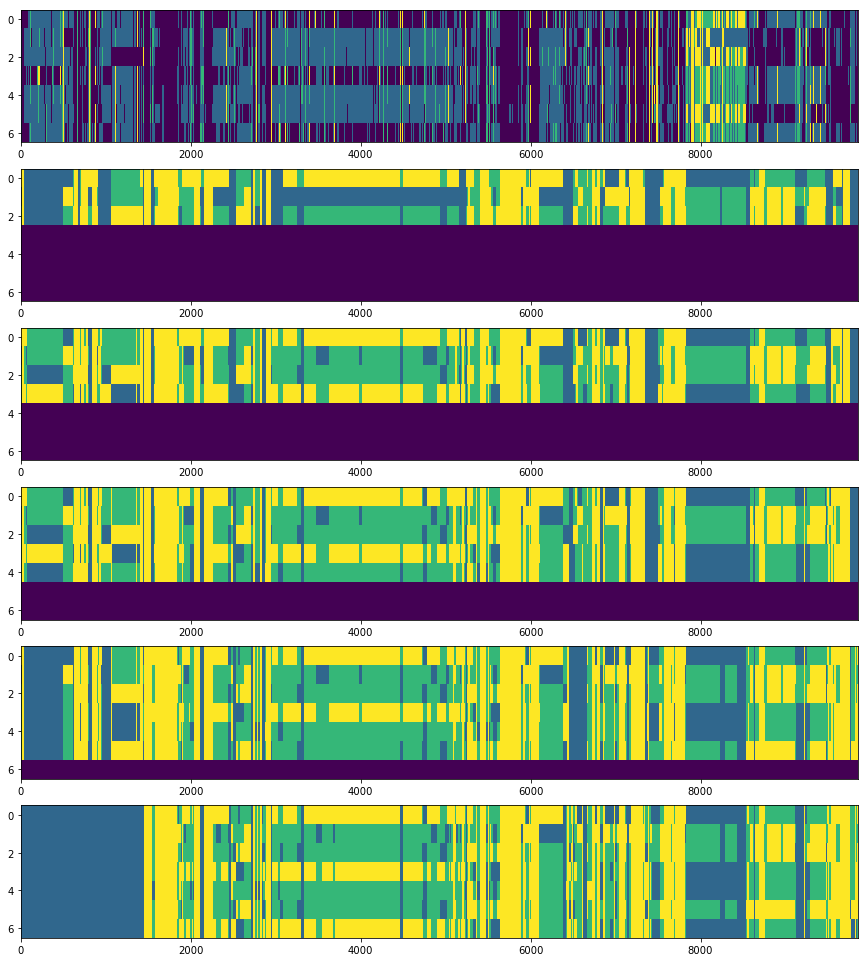

In [235]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))

have_del_indices = np.where(np.sum(deletions>0, axis=(0, 1))>0)[0]

plt.subplot(7, 1, 1)
plt.imshow(whole_chrom[:, have_del_indices], aspect='auto', vmin=-1, vmax=2)

for i in range(3, 8):
    plt.subplot(7, 1, i-1)
    plt.imshow(deletions[i, :, have_del_indices].T, aspect='auto', vmin=-1, vmax=2)

plt.show()

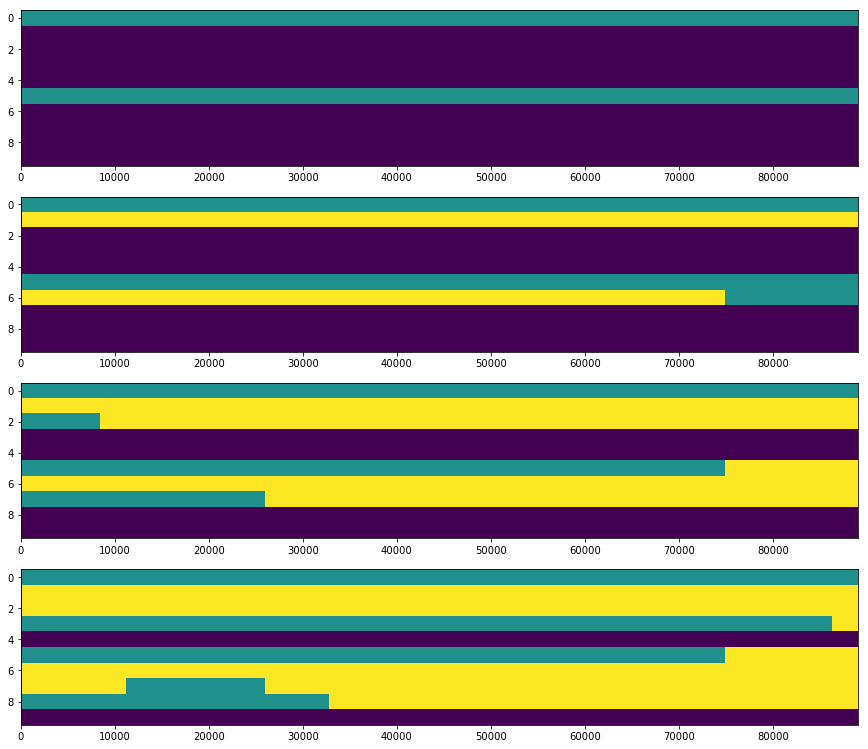

In [240]:
plt.figure(figsize=(15, 20))

have_del_indices = np.where(np.sum(deletions>0, axis=(0, 1))>0)[0]

for i in range(3, 7):
    plt.subplot(6, 1, i-2)
    plt.imshow(np.vstack((inh_state[i, :, 0, :], inh_state[i, :, 1, :])), aspect='auto', vmin=-1, vmax=1)

plt.show()

3 [[ 11114    452   1031]
 [   384   6910   3486]
 [   310   1073 242186]]
4 [[ 15922    647    751]
 [   475  11565   1287]
 [   895   2214 322172]]
5 [[ 19332    344    434]
 [   315  16223   1159]
 [   794   2735 403574]]
6 [[ 24039      0      0]
 [     0  21899      0]
 [     0      0 487954]]


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


7 [[ 20585    402   3052]
 [   641  19149   2109]
 [   458   1233 486263]]


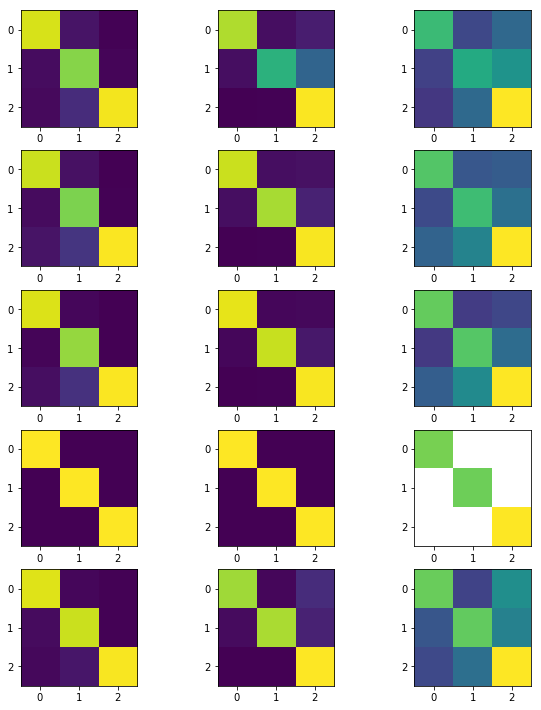

In [231]:
plt.figure(figsize=(10, 15))
s = 1
for i in range(3, 8):
    contingency = np.asarray([[np.sum((deletions[i, :i, :]==2) & (deletions[6, :i, :]==2)),
                   np.sum((deletions[i, :i, :]==1) & (deletions[6, :i, :]==2)),
                   np.sum((deletions[i, :i, :]==0) & (deletions[6, :i, :]==2))],
                   [np.sum((deletions[i, :i, :]==2) & (deletions[6, :i, :]==1)),
                   np.sum((deletions[i, :i, :]==1) & (deletions[6, :i, :]==1)),
                   np.sum((deletions[i, :i, :]==0) & (deletions[6, :i, :]==1))],
                   [np.sum((deletions[i, :i, :]==2) & (deletions[6, :i, :]==0)),
                   np.sum((deletions[i, :i, :]==1) & (deletions[6, :i, :]==0)),
                   np.sum((deletions[i, :i, :]==0) & (deletions[6, :i, :]==0))]])
                   # 0]]
    plt.subplot(6, 3, s)
    plt.imshow(contingency/np.sum(contingency, axis=0), vmin=0, vmax=1)
    s += 1
    plt.subplot(6, 3, s)
    plt.imshow((contingency.T/np.sum(contingency, axis=1)).T, vmin=0, vmax=1)
    s += 1
    plt.subplot(6, 3, s)
    plt.imshow(np.log10(contingency), vmin=2, vmax=5)
    s += 1
    print(i, contingency)
plt.show()

In [226]:
print(whole_chrom.shape, deletions[7].shape)

(7, 88982) (7, 88982)
